
This is a part of series I am writing, named "**Speed Up Your Algorithms**".

Here is the list of posts with files I have written: [Github-SpeedUpYourAlgorithms](https://github.com/PuneetGrov3r/MediumPosts/tree/master/SpeedUpYourAlgorithms)

# Initial

In [0]:
!pip install numba

In [0]:
# Needed for using cuda with Numba (https://numba.pydata.org/numba-doc/dev/user/installing.html#installing-using-pip-on-x86-x86-64-platforms)
# Numba only supports cuda till 9.1
!apt update -qq;
!wget https://developer.nvidia.com/compute/cuda/8.0/Prod2/local_installers/cuda-repo-ubuntu1604-8-0-local-ga2_8.0.61-1_amd64-deb
!mv cuda-repo-ubuntu1604-8-0-local-ga2_8.0.61-1_amd64-deb cuda-repo-ubuntu1604-8-0-local-ga2_8.0.61-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-8-0-local-ga2_8.0.61-1_amd64.deb
!apt-get update -qq;
!apt-get install cuda-8-0 gcc-5 g++-5 -y -qq;
!ln -s /usr/bin/gcc-5 /usr/local/cuda/bin/gcc;
!ln -s /usr/bin/g++-5 /usr/local/cuda/bin/g++;

In [0]:
import os
os.environ["NUMBAPRO_CUDA_DRIVER"] = "/usr/lib64-nvidia/libcuda.so"
os.environ["NUMBAPRO_NVVM"] = "/usr/local/cuda-8.0/nvvm/lib64/libnvvm.so"
os.environ["NUMBAPRO_LIBDEVICE"] = "/usr/local/cuda-8.0/nvvm/libdevice/"
#os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda/lib64"

In [4]:
!numba -s

System info:
--------------------------------------------------------------------------------
__Time Stamp__
2018-11-03 19:05:03.352049

__Hardware Information__
Machine                                       : x86_64
CPU Name                                      : haswell
Number of accessible CPU cores                : 2
Listed accessible CPUs cores                  : 0-1
CFS restrictions                              : None
CPU Features                                  : 
aes avx avx2 bmi bmi2 cmov cx16 f16c fma fsgsbase lzcnt mmx movbe pclmul popcnt
rdrnd sse sse2 sse3 sse4.1 sse4.2 ssse3 xsave xsaveopt

__OS Information__
Platform                                      : Linux-4.14.65+-x86_64-with-Ubuntu-18.04-bionic
Release                                       : 4.14.65+
System Name                                   : Linux
Version                                       : #1 SMP Sun Sep 9 02:18:33 PDT 2018
OS specific info                              : Ubuntu18.04bionic
glibc info   

# Import

In [0]:
import os
import numpy as np # Numba supports many functions from numpy (https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html)
from numba import jit, njit, vectorize, cuda
import math # Numba supports many functions from math (http://numba.pydata.org/numba-doc/0.17.0/reference/pysupported.html)

import matplotlib.pyplot as plt

# 4. Using basic numba functionalities (Just @jit it!)

In [0]:
a = np.ones((1, 100), dtype=np.float64)
b = np.ones((100, 1), dtype=np.float64)

In [0]:
#
# Simple Python function
#

def func(a, b):
  for i in range(100000):
    constant = math.pow((a@b)[0][0], 1./2)/math.exp((a@b)[0][0]/1000)
    a = np.array([[constant]*100], dtype=np.float64)
  return a

In [8]:
%timeit res = func(a, b)

1 loop, best of 3: 775 ms per loop


In [0]:
#
# Numba with nopython = True
#

@njit      # or @jit(nopython=True)
def njit_func(a, b):
  for i in range(100000):
    constant = math.pow((a@b)[0][0], 1./2)/math.exp((a@b)[0][0]/1000)
    a = np.array([[constant]*100], dtype=np.float64)
  return a

In [18]:
%timeit res = njit_func(a, b)

10 loops, best of 3: 109 ms per loop


In [0]:
#
# Basic Numba compiler with type information provided
#

@jit('float64(float64, float64)')
def jit_func(a, b):
  for i in range(100000):
    constant = math.pow((a@b)[0][0], 1./2)/math.exp((a@b)[0][0]/1000)
    a = np.array([[constant]*100], dtype=np.float64)
  return a

In [17]:
%timeit res = jit_func(a, b)

10 loops, best of 3: 109 ms per loop


Text(0.5,0,'Method')

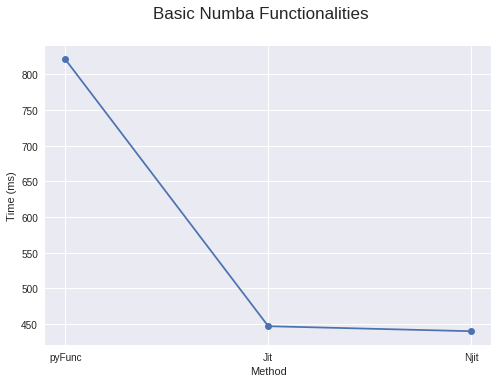

In [27]:
fig, ax = plt.subplots(1, 1)
ax.plot(["a", "b", "c"], [821, 447, 440], "-o") # Results without caching
ax.set_xticklabels(["pyFunc", "Jit", "Njit"])
fig.suptitle("Basic Numba Functionalities", fontsize=17)
ax.set_ylabel("Time (ms)")
ax.set_xlabel("Method")

# 5. The @vectorize wrapper

In [0]:
#
# Making Ufuncs with Numba.
#

@vectorize
def vec_func(a, b):
  # Now we can pass arrays too, and operate
  # inside like they are scalars:
  for i in range(100000):
    a = math.pow(a*b, 1./2)/math.exp(a*b/1000)
  return a
# This is similar to functions before, for comparison. But...

In [20]:
%timeit res = vec_func(a, b)

1 loop, best of 3: 35.4 s per loop


In [0]:
#
# This is slow because previously we were doing some
# operations on 1,00,000 scalars obtained by multiplying
# (a@b), but now we are multiplying individual elements 
# of a and b for 1,00,000 times. Also numba is taking care
# of broadcasting too. So, in this case we are applying this
# loop for 100 times.
#
res.shape # Previously it was (1, 100)

In [0]:
@vectorize(['float64(float64, float64)'], target='parallel')
def vecParallel_func(a, b):
  for i in range(100000):
    a = math.pow(a*b, 1./2)/math.exp(a*b/1000)
  return a

In [23]:
%timeit res = vecParallel_func(a, b)

1 loop, best of 3: 18.6 s per loop


In [0]:
@vectorize(['float64(float64, float64)'], target='cuda')
def vecCuda_func(a, b):
  for i in range(100000):
    a = math.pow(a*b, 1./2)/math.exp(a*b/1000)
  return a

In [25]:
%timeit res = vecCuda_func(a, b)

1 loop, best of 3: 282 ms per loop


In [0]:
# Woah!!

Text(0.5,0,'Method')

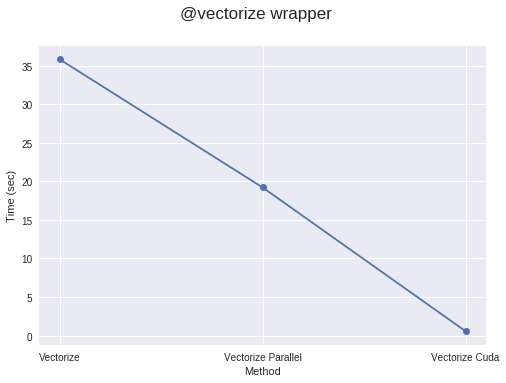

In [162]:
fig, ax = plt.subplots(1, 1)
ax.plot(["a", "b", "c"], [35.8, 19.2, 0.568], "-o")
ax.set_xticklabels(["Vectorize", "Vectorize Parallel", "Vectorize Cuda"])
fig.suptitle("@vectorize wrapper", fontsize=17)
ax.set_ylabel("Time (sec)")
ax.set_xlabel("Method")

# 6. Running your functions on GPU


In [0]:
@cuda.jit
def cudaKernal_func(a, b, result): # cuda.jit does not return result yet
  pos = cuda.grid(1)
  if (pos < a.shape[1]) and (pos < b.shape[0]):
    for i in range(100000):
      result[pos] = math.exp(a[0][pos]*b[pos][0])

In [0]:
result = np.zeros((100,), dtype=np.float64)

In [30]:
threadsperblock = 32
blockspergrid = (100 + 31) // 32 # blockspergrid = (array.size + (threadsperblock - 1)) // threadsperblock

%timeit cudaKernal_func[threadsperblock, blockspergrid](a, b, result)

1 loop, best of 3: 66.2 ms per loop


In [31]:
result.shape

(100,)

In [0]:
#
# Here, we have only used it for 1D arrays. You can use it for any Tensor. For eg:
# For 2D array operations you would have used: x, y = cuda.grid(2)
#

In [0]:
@cuda.jit(device=True)
def cudaDevice_func(a, b):
  for i in range(100000):
    a = math.exp(a*b)
  return a

In [0]:
@cuda.jit
def cudaKernal_func2(a, b, result): # cuda.jit does not return result yet
  pos = cuda.grid(1)
  if (pos < a.shape[1]) and (pos < b.shape[0]):
    result[pos] = cudaDevice_func(a[0][pos], b[pos][0])

In [35]:
%timeit cudaKernal_func2[threadsperblock, blockspergrid](a, b, result)

The slowest run took 5.08 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 41.4 ms per loop
